### Creacion de datos
---
* Crear datos para pruebas, aplicar una convolucion gausiana (PSF) al mapa de santiago con el punto central en donde se midio ..

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [86]:
from netCDF4 import Dataset
#dataset = Dataset('../HC_TOT.nc',mode='r') 
dataset = Dataset('sample_files//NOx_TOT.nc',mode='r') 
print("Dimensiones: ",dataset.dimensions.keys() )
measure = dataset.variables['NOxTOT']
measure_data = measure[:]
W,H = measure.shape
print("HC TOT unit: ",measure.units)
print("HC TOT min value: ",measure.min)
print("HC TOT max value: ",measure.max)
print("HC TOT shape: ",measure.shape)

lons = dataset.variables['longitude']
lons_data = lons[:]

lats = dataset.variables['latitude']
lats_data = lats[:]

#aprox square over santiago --- coordinates
start_long = lons_data[630]
end_long = lons_data[680]

start_lat = lats_data[1570]
end_lat = lats_data[1630]

print("Start longitude %f - End Longitute %f"%(start_long,end_long))
print("Start latitude %f - End latitude %f"%(start_lat,end_lat))

precision_degrees = 0.01

dataset.close()

Dimensiones:  odict_keys(['longitude', 'latitude'])
HC TOT unit:  ton/yr
HC TOT min value:  0.0
HC TOT max value:  282.272216797
HC TOT shape:  (3913, 1157)


In [98]:
W , H = 50, 60

In [110]:
folder = "../proyecto/datasets/"

df_independencia_verano = pd.read_csv(folder+"dump-Independencia_2018-04-12_230000-verano.csv")
df_independencia_invierno = pd.read_csv(folder+"dump-Independencia_2018-04-12_230000-invierno.csv")

df_condes_verano = pd.read_csv(folder+"dump-Las_Condes_2018-04-12_230000-verano.csv")
df_condes_invierno = pd.read_csv(folder+"dump-Las_Condes_2018-04-12_230000-invierno.csv")

df_independencia_invierno.head()

,registered_on,CO,PM10,PM25,NO2,NO,NOX,SO2,WD,RH,TEMP,WS,HCNM,UVA,UVB,O3
0,1997-05-01 01:00:00,1.1,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,1997-05-01 02:00:00,1.6,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,1997-05-01 03:00:00,1.9,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,1997-05-01 04:00:00,2.2,104.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4,1997-05-01 05:00:00,1.7,87.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [90]:
#latitude and longitude coordinates
LC_lat = -33.414429
LC_long = -70.557030
IND_lat = -33.422390
IND_long =  -70.655200


LC_i = int(round((LC_lat-start_lat)/precision_degrees))
LC_j = int(round((LC_long-start_long)/precision_degrees))

IND_i = int(round((IND_lat-start_lat)/precision_degrees))
IND_j = int(round((IND_long-start_long)/precision_degrees))

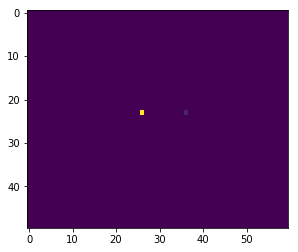

In [105]:

a = np.zeros((W,H))

a[LC_i,LC_j] = 10
a[IND_i,IND_j] =100

plt.imshow(a)
plt.show()

In [112]:
#data creation...
data_ind = []

for value in df_independencia_invierno.values:
#for value in df_condes_verano.values:
    a = np.zeros((W,H))
    #a[LC_i,LC_j] = 10
    a[IND_i,IND_j] = value[-1] #ozone

    data_ind.append(a)    
data_ind = np.asarray(data_ind)
data_ind.shape

(60814, 50, 60)

In [46]:
from scipy.stats import multivariate_normal
from scipy.signal import convolve2d

def makeGaussian(size1,size2, sigma1 = 3,sigma2=3):
    """ Make a square gaussian kernel """
    mu = np.asarray([size1//2,size2//2]) # [x0, y0]
    cov = np.asarray([sigma1,sigma2])

    normal_distrib = multivariate_normal(mu,cov)
    normal_factor = 1/normal_distrib.pdf(mu)
    
    result = np.zeros((size1,size2))
    for i in range(size1):
        for j in range(size2):
            result[i,j] = normal_distrib.pdf([i,j])*normal_factor
    return result, normal_factor

psf, normal_factor = makeGaussian(W,H,W,H)

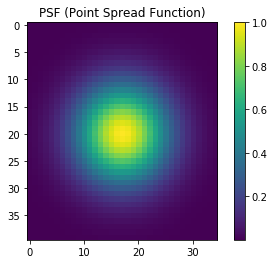

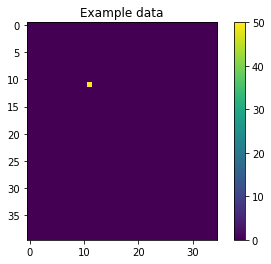

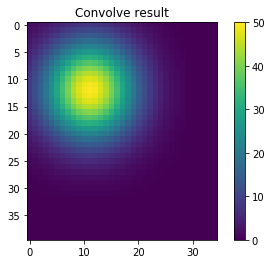

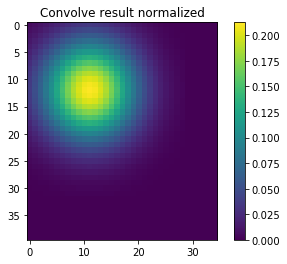

47.419251478863707

In [47]:
plt.imshow(psf)
plt.colorbar()
plt.title("PSF (Point Spread Function)")
plt.show()

a = np.zeros(psf.shape)
i = np.random.randint(0,a.shape[0])
j = np.random.randint(0,a.shape[1])
a[i,j] = 50 #measurement
plt.imshow(a)
plt.title("Example data")
plt.colorbar()
plt.show()

operat = convolve2d(a, psf, mode='same', boundary='fill', fillvalue=0)
plt.imshow(operat)
plt.title("Convolve result")
plt.colorbar()
plt.show()

operat = convolve2d(a, psf/normal_factor, mode='same', boundary='fill', fillvalue=0)
plt.imshow(operat)
plt.title("Convolve result normalized")
plt.colorbar()
plt.show()
np.sum(operat)

In [114]:
#timestep_data = np.zeros((T,W,H))

def convolve_cube(cube,PSF):
    new_timestep_data = np.zeros(cube.shape)
    for t in range(new_timestep_data.shape[0]):
        #i = np.random.randint(0,new_timestep_data.shape[1])
        #j = np.random.randint(0,new_timestep_data.shape[2])
        #timestep_data[t,i,j] = np.random.randint(1,50)

        new_timestep_data[t] = convolve2d(cube[t], PSF, mode='same', boundary='fill', fillvalue=0)
    return new_timestep_data


new_cube_data = convolve_cube(data_ind,psf)

new_cube_data.shape

KeyboardInterrupt: 

In [ ]:
t

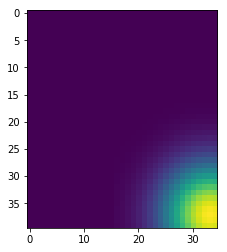

In [49]:
plt.imshow(new_timestep_data[2])
plt.show()

In [ ]:
#when data cubes are create create timestep data.. with index (Efficient)

In [36]:
N = 5 #data
T = 8 #timesteps (hours)
Ch = 10 #channels of the cube (number of compound)
input_data = np.zeros((N,T,W,H,Ch))
print("(data, timesteps, width, heigh, channels):",input_data.shape)

(data, timesteps, width, heigh, channels): (5, 8, 40, 35, 10)
